In [ ]:
!pip install -q -U transformers==4.37.2
!pip install -q bitsandbytes==0.41.3 accelerate==0.25.0
!pip install -q git+https://github.com/openai/whisper.git
!pip install -q gradio
!pip install -q gTTS
!pip install -U trl
!pip install accelerate
!pip install -q -U peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 27.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.4/314.4 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:
import torch
from transformers import BitsAndBytesConfig, pipeline
from peft import PeftModel
from transformers import LlavaForConditionalGeneration, BitsAndBytesConfig
import time
import warnings
import os
from gtts import gTTS
from PIL import Image
import nltk
nltk.download('punkt')
from nltk import sent_tokenize
import locale
import gradio as gr
import base64
import re
import requests
import datetime
import whisper
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from huggingface_hub import login, logout

login()

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
model_id = "GURU369/llava-1.5-7b-hf-ft-merged"

In [ ]:
quantization_config = BitsAndBytesConfig(
                      load_in_4bit=True,
                      bnb_4bit_compute_dtype=torch.float16
                      )
pipe = pipeline("image-to-text",
                model=model_id,
                model_kwargs={"quantization_config": quantization_config})

adapter_config.json:   0%|          | 0.00/927 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


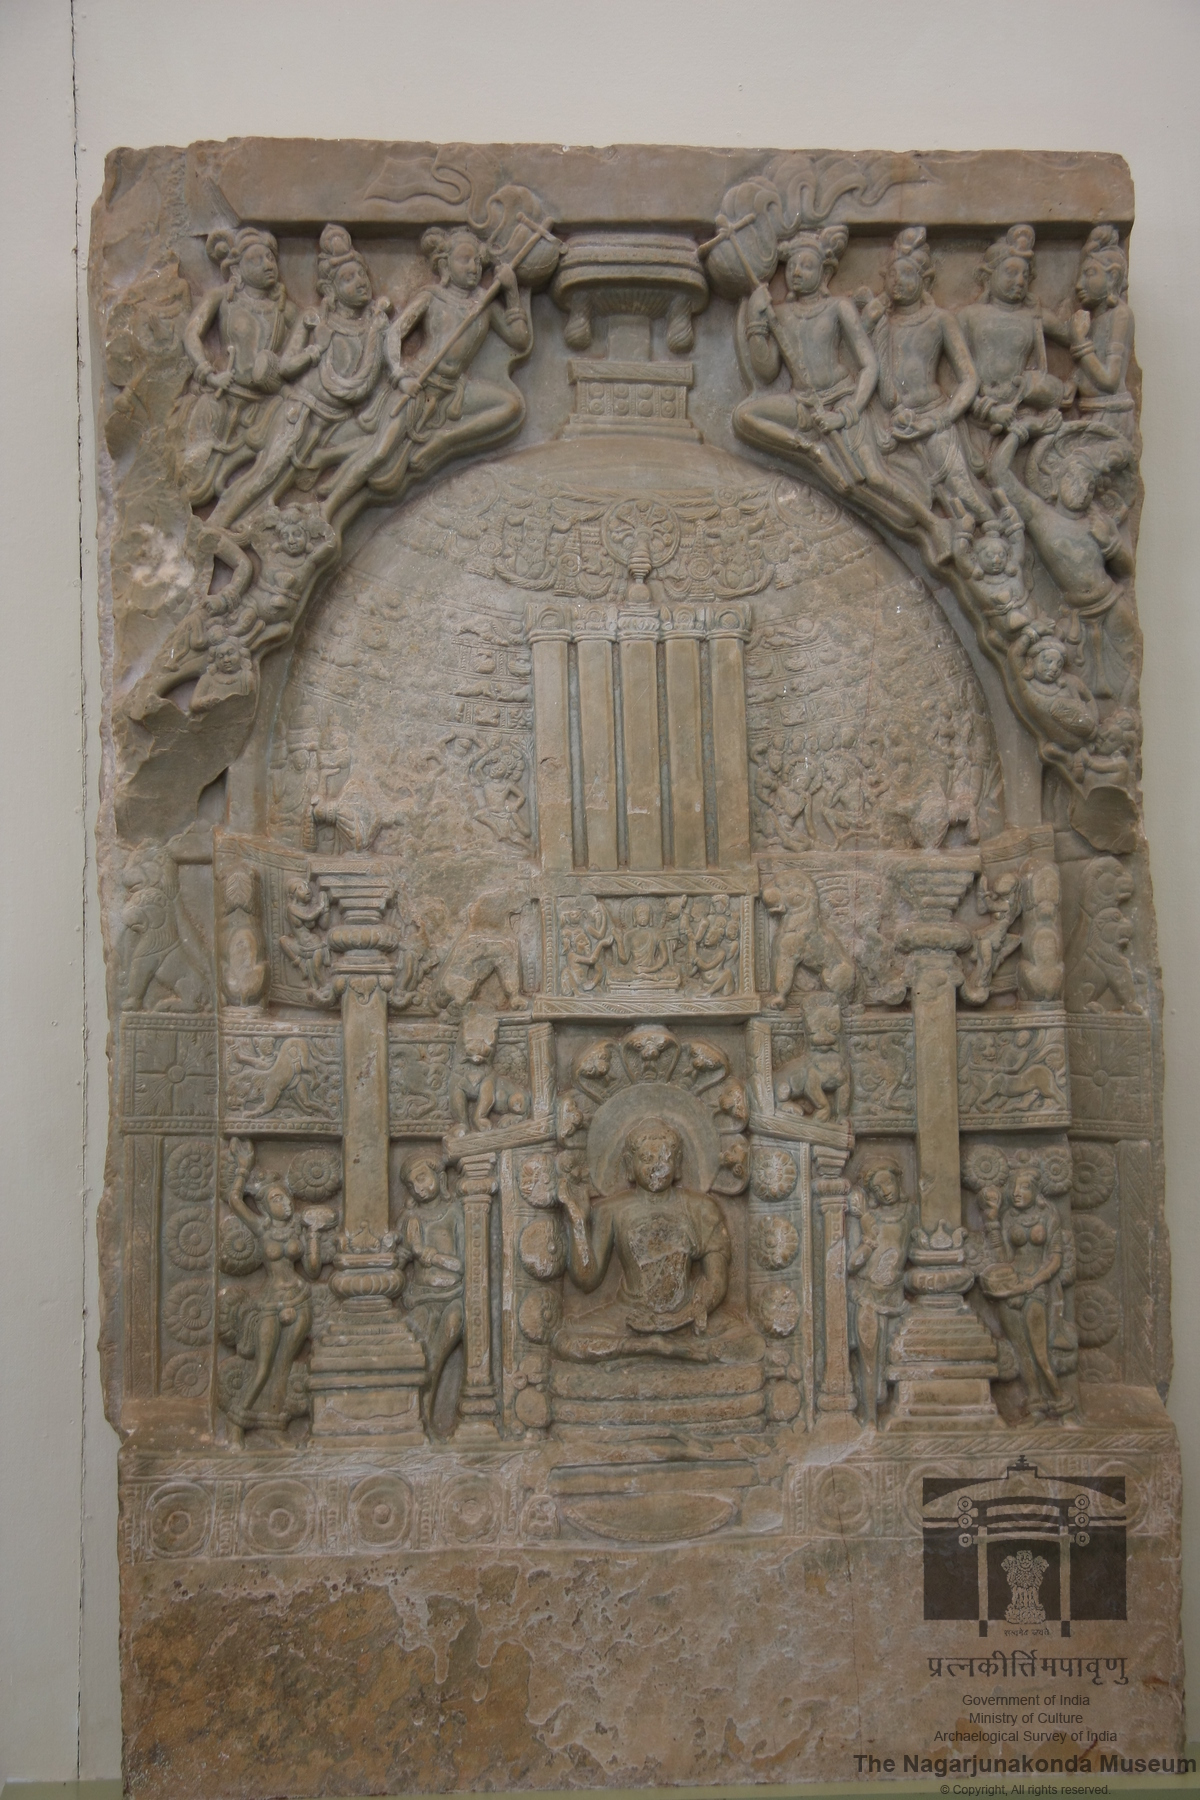

In [ ]:
image_path = "/content/nkm_hyd-mar-scu-0004-0_01_h.jpg" #upload an image from the scraped data for inferring
image = Image.open((image_path))
image

In [ ]:
from torchvision import transforms
from PIL import Image

# Load and transform the image
def load_and_transform_image(image_path):
    # Define the transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to the required input dimensions of the model
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to match the model's training
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add a batch dimension
    return image

# Load the image with the transformation
image_tensor = load_and_transform_image(image_path)

# Now pass this image_tensor to the pipeline


### Inferring / Querying - 1

In [ ]:
prompt_instructions = """
Please provide a comprehensive and detailed analysis of this image. Describe the visual elements (e.g., colors, shapes, composition), the artistic style and techniques used, any identifiable subjects or themes, and the historical context or significance of the artwork. Additionally, consider the emotional or psychological impact the artwork might have on viewers.
"""

prompt = "USER: <image>\n" + prompt_instructions +"\nASSISTANT:"

outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 400})
for sentence in sent_tokenize(outputs[0]["generated_text"]):
    print(sentence)


USER:  

Please provide a comprehensive and detailed analysis of this image.
Describe the visual elements (e.g., colors, shapes, composition), the artistic style and techniques used, any identifiable subjects or themes, and the historical context or significance of the artwork.
Additionally, consider the emotional or psychological impact the artwork might have on viewers.
ASSISTANT: The image features a large, intricately carved stone sculpture, possibly depicting a religious figure or a historical figure.
The sculpture is set in a stone frame, which adds to its grandeur.
The artwork is rich in detail, with various figures and elements carved into the stone.
There are several people in the scene, with some of them appearing to be engaged in a conversation.
The artwork also includes a clock, which adds a unique element to the composition.
The overall effect of the sculpture is one of historical significance and artistic beauty, capturing the viewer's attention and evoking a sense of awe